In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Large
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_bfloat16')


print(tf.__version__)

2.13.0


In [2]:
dataset = {
    "train_data": r"G:\Datasets\New Plant Diseases\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train",
    "valid_data": r"G:\Datasets\New Plant Diseases\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid",
    "test_data": r"G:\Datasets\New Plant Diseases\test"
}

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

In [3]:
valid_df , test_df = train_test_split(valid_df ,  train_size= 0.90 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

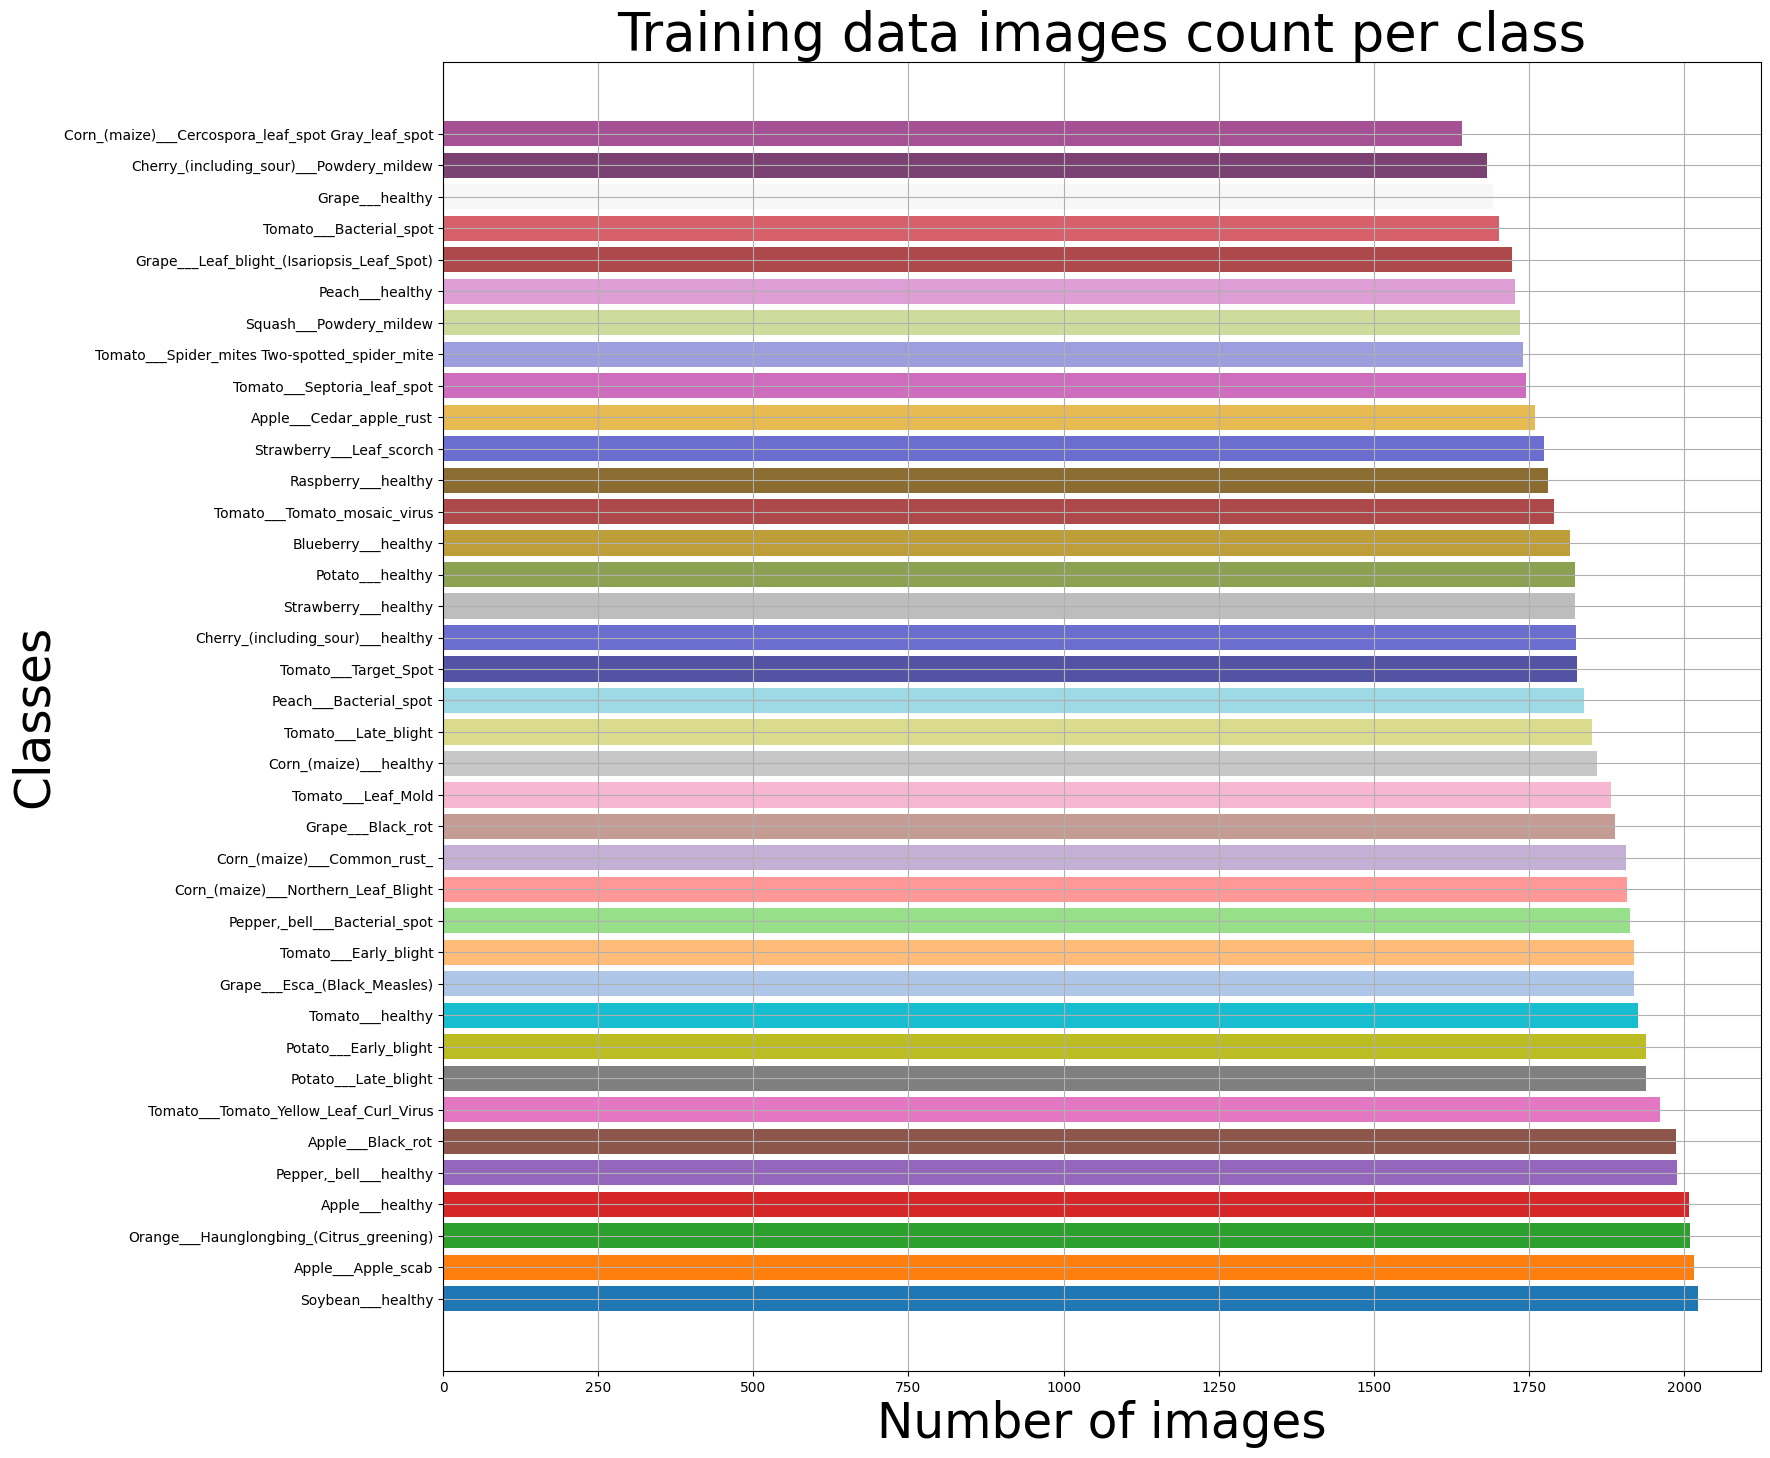

In [4]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]


plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [5]:
train_df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
59490,G:\Datasets\New Plant Diseases\New Plant Disea...,Tomato___Leaf_Mold,31
58840,G:\Datasets\New Plant Diseases\New Plant Disea...,Tomato___Late_blight,30
11750,G:\Datasets\New Plant Diseases\New Plant Disea...,Cherry_(including_sour)___Powdery_mildew,5
19617,G:\Datasets\New Plant Diseases\New Plant Disea...,Corn_(maize)___Northern_Leaf_Blight,9
48429,G:\Datasets\New Plant Diseases\New Plant Disea...,Strawberry___healthy,27
46935,G:\Datasets\New Plant Diseases\New Plant Disea...,Squash___Powdery_mildew,25
42758,G:\Datasets\New Plant Diseases\New Plant Disea...,Potato___Late_blight,21
33007,G:\Datasets\New Plant Diseases\New Plant Disea...,Peach___healthy,17
42522,G:\Datasets\New Plant Diseases\New Plant Disea...,Potato___Late_blight,21
43380,G:\Datasets\New Plant Diseases\New Plant Disea...,Raspberry___healthy,23


In [6]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath              labels
0  G:\Datasets\New Plant Diseases\New Plant Disea...  Apple___Apple_scab
1  G:\Datasets\New Plant Diseases\New Plant Disea...  Apple___Apple_scab
2  G:\Datasets\New Plant Diseases\New Plant Disea...  Apple___Apple_scab
3  G:\Datasets\New Plant Diseases\New Plant Disea...  Apple___Apple_scab
4  G:\Datasets\New Plant Diseases\New Plant Disea...  Apple___Apple_scab
(70295, 3)
--------Validation----------
                                             imgpath  \
0  G:\Datasets\New Plant Diseases\New Plant Disea...   
1  G:\Datasets\New Plant Diseases\New Plant Disea...   
2  G:\Datasets\New Plant Diseases\New Plant Disea...   
3  G:\Datasets\New Plant Diseases\New Plant Disea...   
4  G:\Datasets\New Plant Diseases\New Plant Disea...   

                        labels  
0        Potato___Early_blight  
1  Tomato___Septoria_leaf_spot  
2         Tomato___Late_blight  
3           Tomato___Lea

In [7]:
%%time

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 70295 validated image filenames belonging to 38 classes.
Found 15814 validated image filenames belonging to 38 classes.
Found 1758 validated image filenames belonging to 38 classes.
CPU times: total: 11.2 s
Wall time: 12.3 s


In [8]:
# Load the MobileNetV3 model
pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,  # No need for the pre-trained top layer
    weights='imagenet',
    pooling = max
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model.layers:
    layer.trainable = False

In [9]:
num_classes = len(set(train_images.classes))

inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
pretrain_out = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(pretrain_out)  # Add Global Average Pooling
x = layers.Dense(256)(x)
x = layers.Activation(activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  

In [10]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
1099/1099 [==============================] - 1172s 1s/step - loss: 0.3655 - accuracy: 0.9022 - val_loss: 0.1068 - val_accuracy: 0.9683 - lr: 5.0000e-04
Epoch 2/10
1099/1099 [==============================] - 1156s 1s/step - loss: 0.0942 - accuracy: 0.9717 - val_loss: 0.0920 - val_accuracy: 0.9709 - lr: 5.0000e-04
Epoch 3/10
1099/1099 [==============================] - 1132s 1s/step - loss: 0.0638 - accuracy: 0.9807 - val_loss: 0.0647 - val_accuracy: 0.9783 - lr: 5.0000e-04
Epoch 4/10
1099/1099 [==============================] - 1114s 1s/step - loss: 0.0492 - accuracy: 0.9847 - val_loss: 0.0523 - val_accuracy: 0.9825 - lr: 5.0000e-04
Epoch 5/10
1099/1099 [==============================] - 1114s 1s/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0516 - val_accuracy: 0.9836 - lr: 5.0000e-04
Epoch 6/10
1099/1099 [==============================] - 1113s 1s/step - loss: 0.0356 - accuracy: 0.9888 - val_loss: 0.0543 - val_accuracy: 0.9819 - lr: 5.0000e-04
Epoch 7/10
1099/1099 [

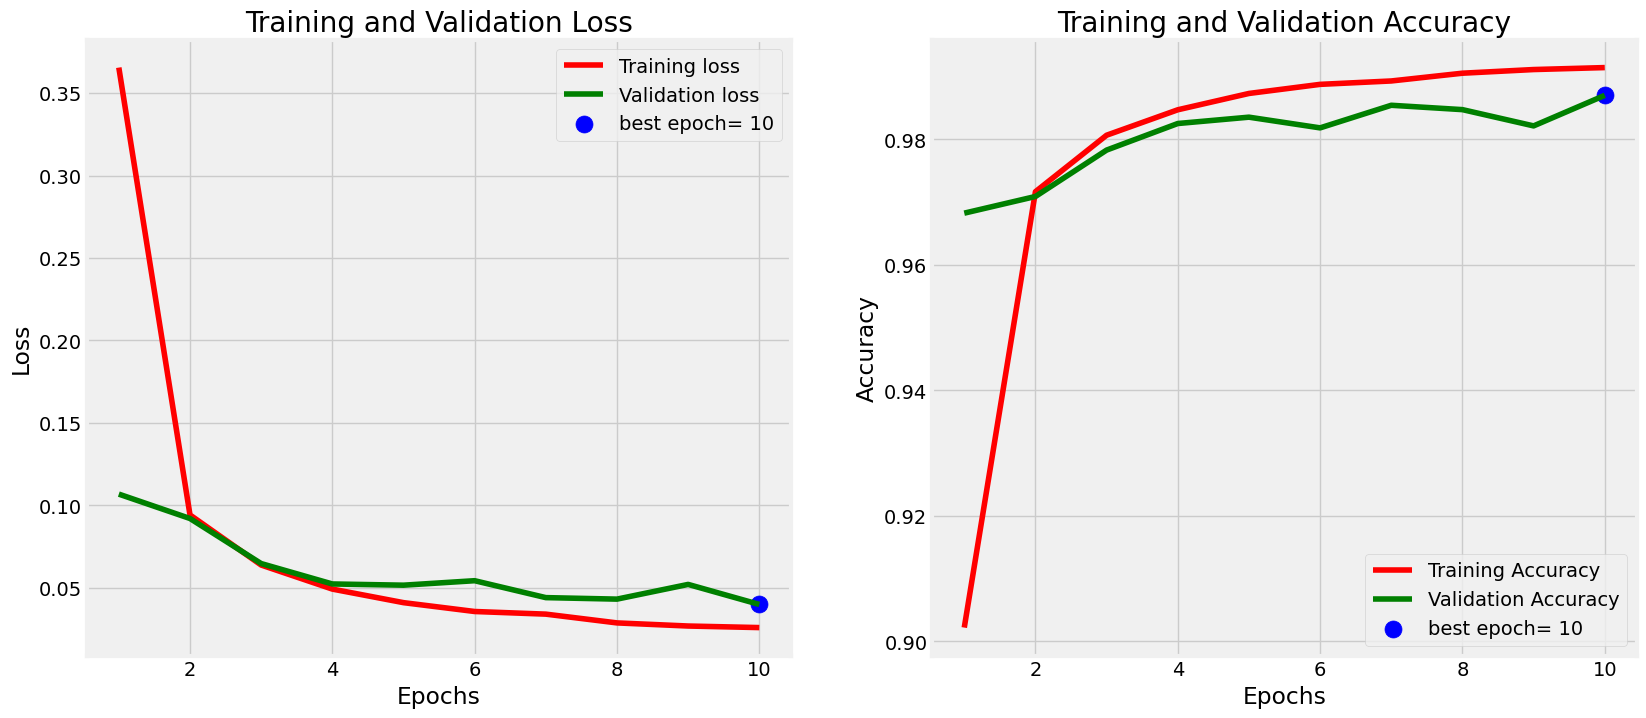

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
Conv True
Conv/BatchNorm False
tf.__operators__.add True
re_lu True
tf.math.multiply True
multiply True
expanded_conv/depthwise True
expanded_conv/depthwise/BatchNorm False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                          

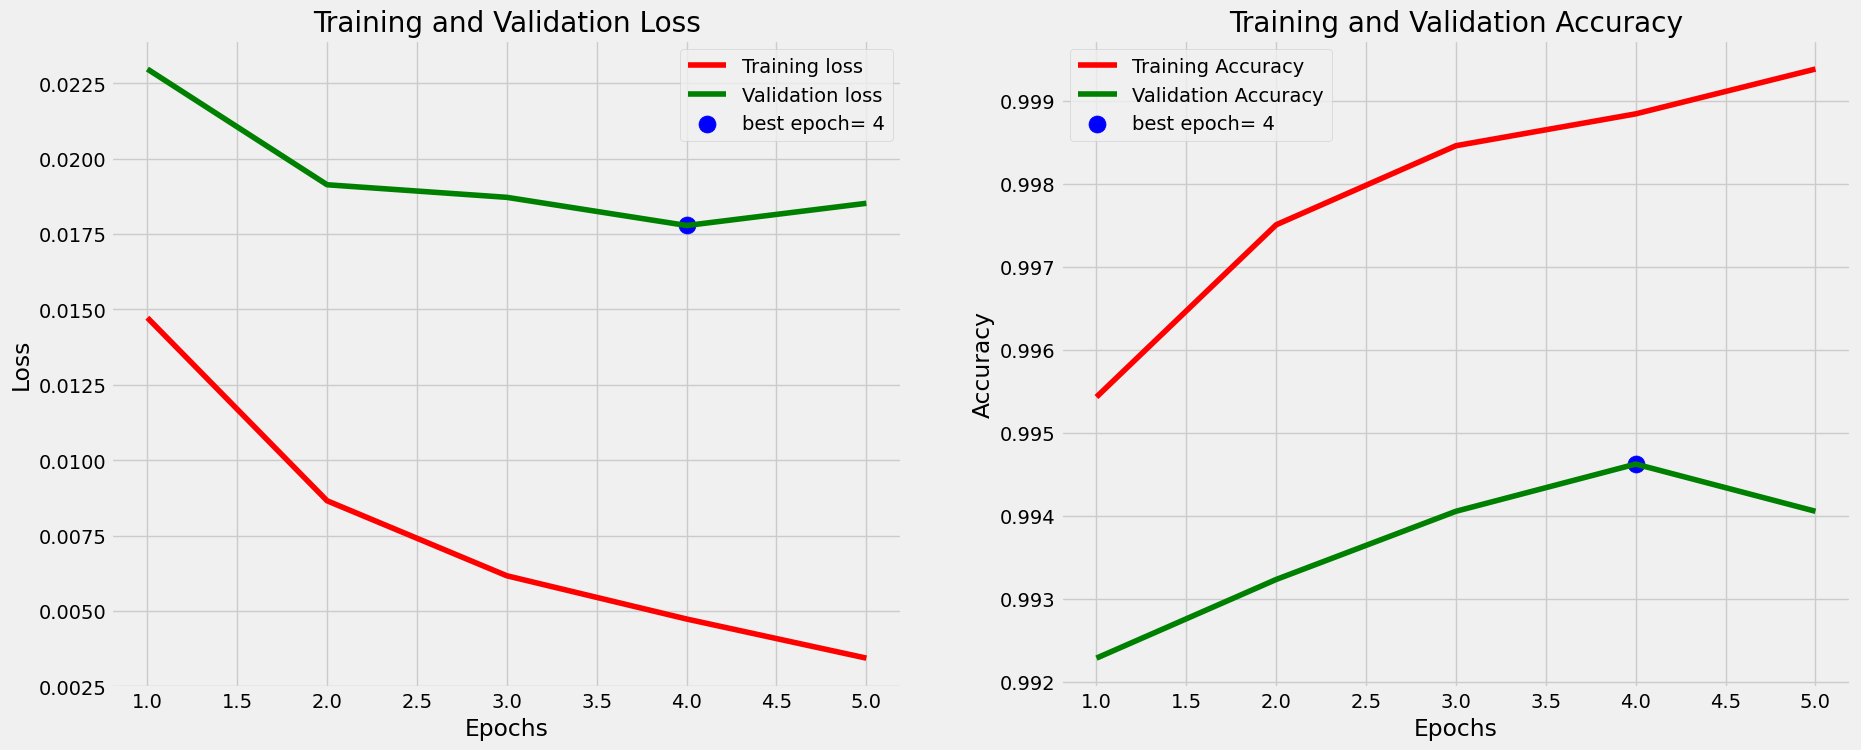

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01835
Test Accuracy: 99.37%


In [15]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

28/28 [==============================] - 28s 884ms/step
F1 Score: 0.9938369068728377
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99        58
                                 Apple___Black_rot       1.00      1.00      1.00        53
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        40
                                   Apple___healthy       1.00      0.98      0.99        53
                               Blueberry___healthy       1.00      1.00      1.00        40
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        37
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        47
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.97      0.99        36
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00     

In [16]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

28/28 [==============================] - 26s 858ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,1,Apple___Black_rot,1,Apple___Black_rot,G:\Datasets\New Plant Diseases\New Plant Disea...,0.999998
1,1,29,Tomato___Early_blight,29,Tomato___Early_blight,G:\Datasets\New Plant Diseases\New Plant Disea...,0.999725
2,2,37,Tomato___healthy,37,Tomato___healthy,G:\Datasets\New Plant Diseases\New Plant Disea...,1.000000
3,3,24,Soybean___healthy,24,Soybean___healthy,G:\Datasets\New Plant Diseases\New Plant Disea...,0.999783
4,4,31,Tomato___Leaf_Mold,31,Tomato___Leaf_Mold,G:\Datasets\New Plant Diseases\New Plant Disea...,1.000000
5,5,35,Tomato___Tomato_Yellow_Leaf_Curl_Virus,35,Tomato___Tomato_Yellow_Leaf_Curl_Virus,G:\Datasets\New Plant Diseases\New Plant Disea...,1.000000
6,6,31,Tomato___Leaf_Mold,31,Tomato___Leaf_Mold,G:\Datasets\New Plant Diseases\New Plant Disea...,0.999866
7,7,19,"Pepper,_bell___healthy",19,"Pepper,_bell___healthy",G:\Datasets\New Plant Diseases\New Plant Disea...,0.999472


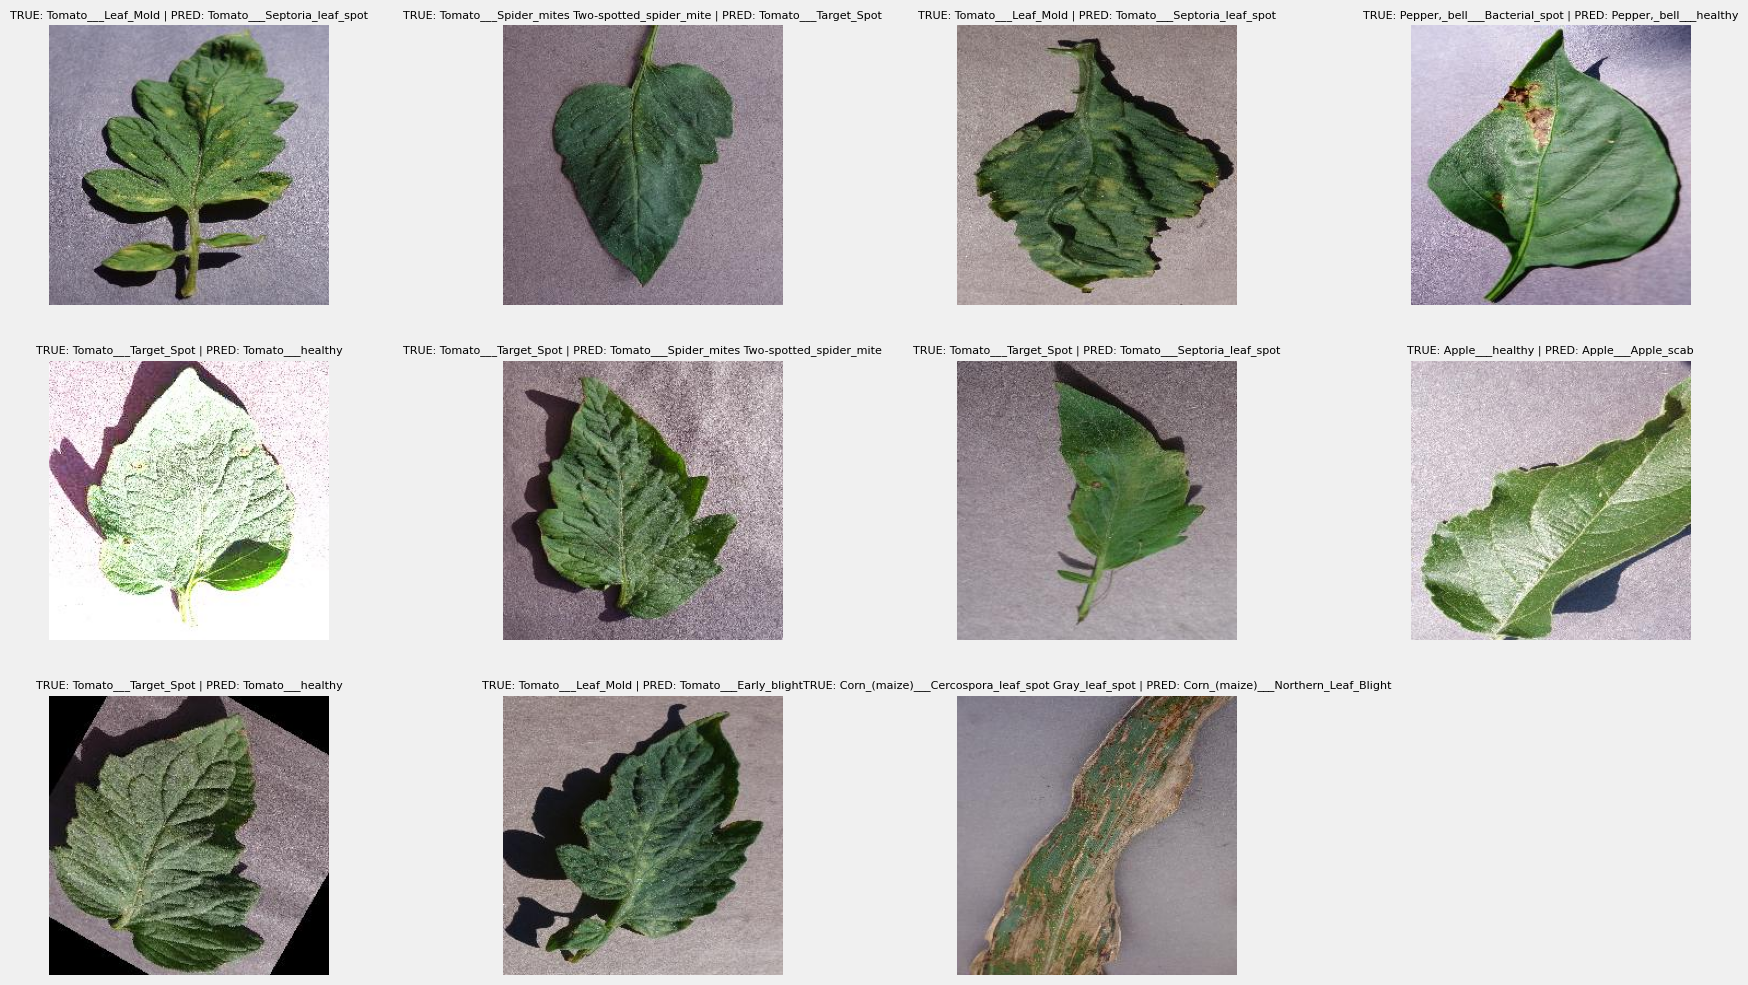

In [17]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

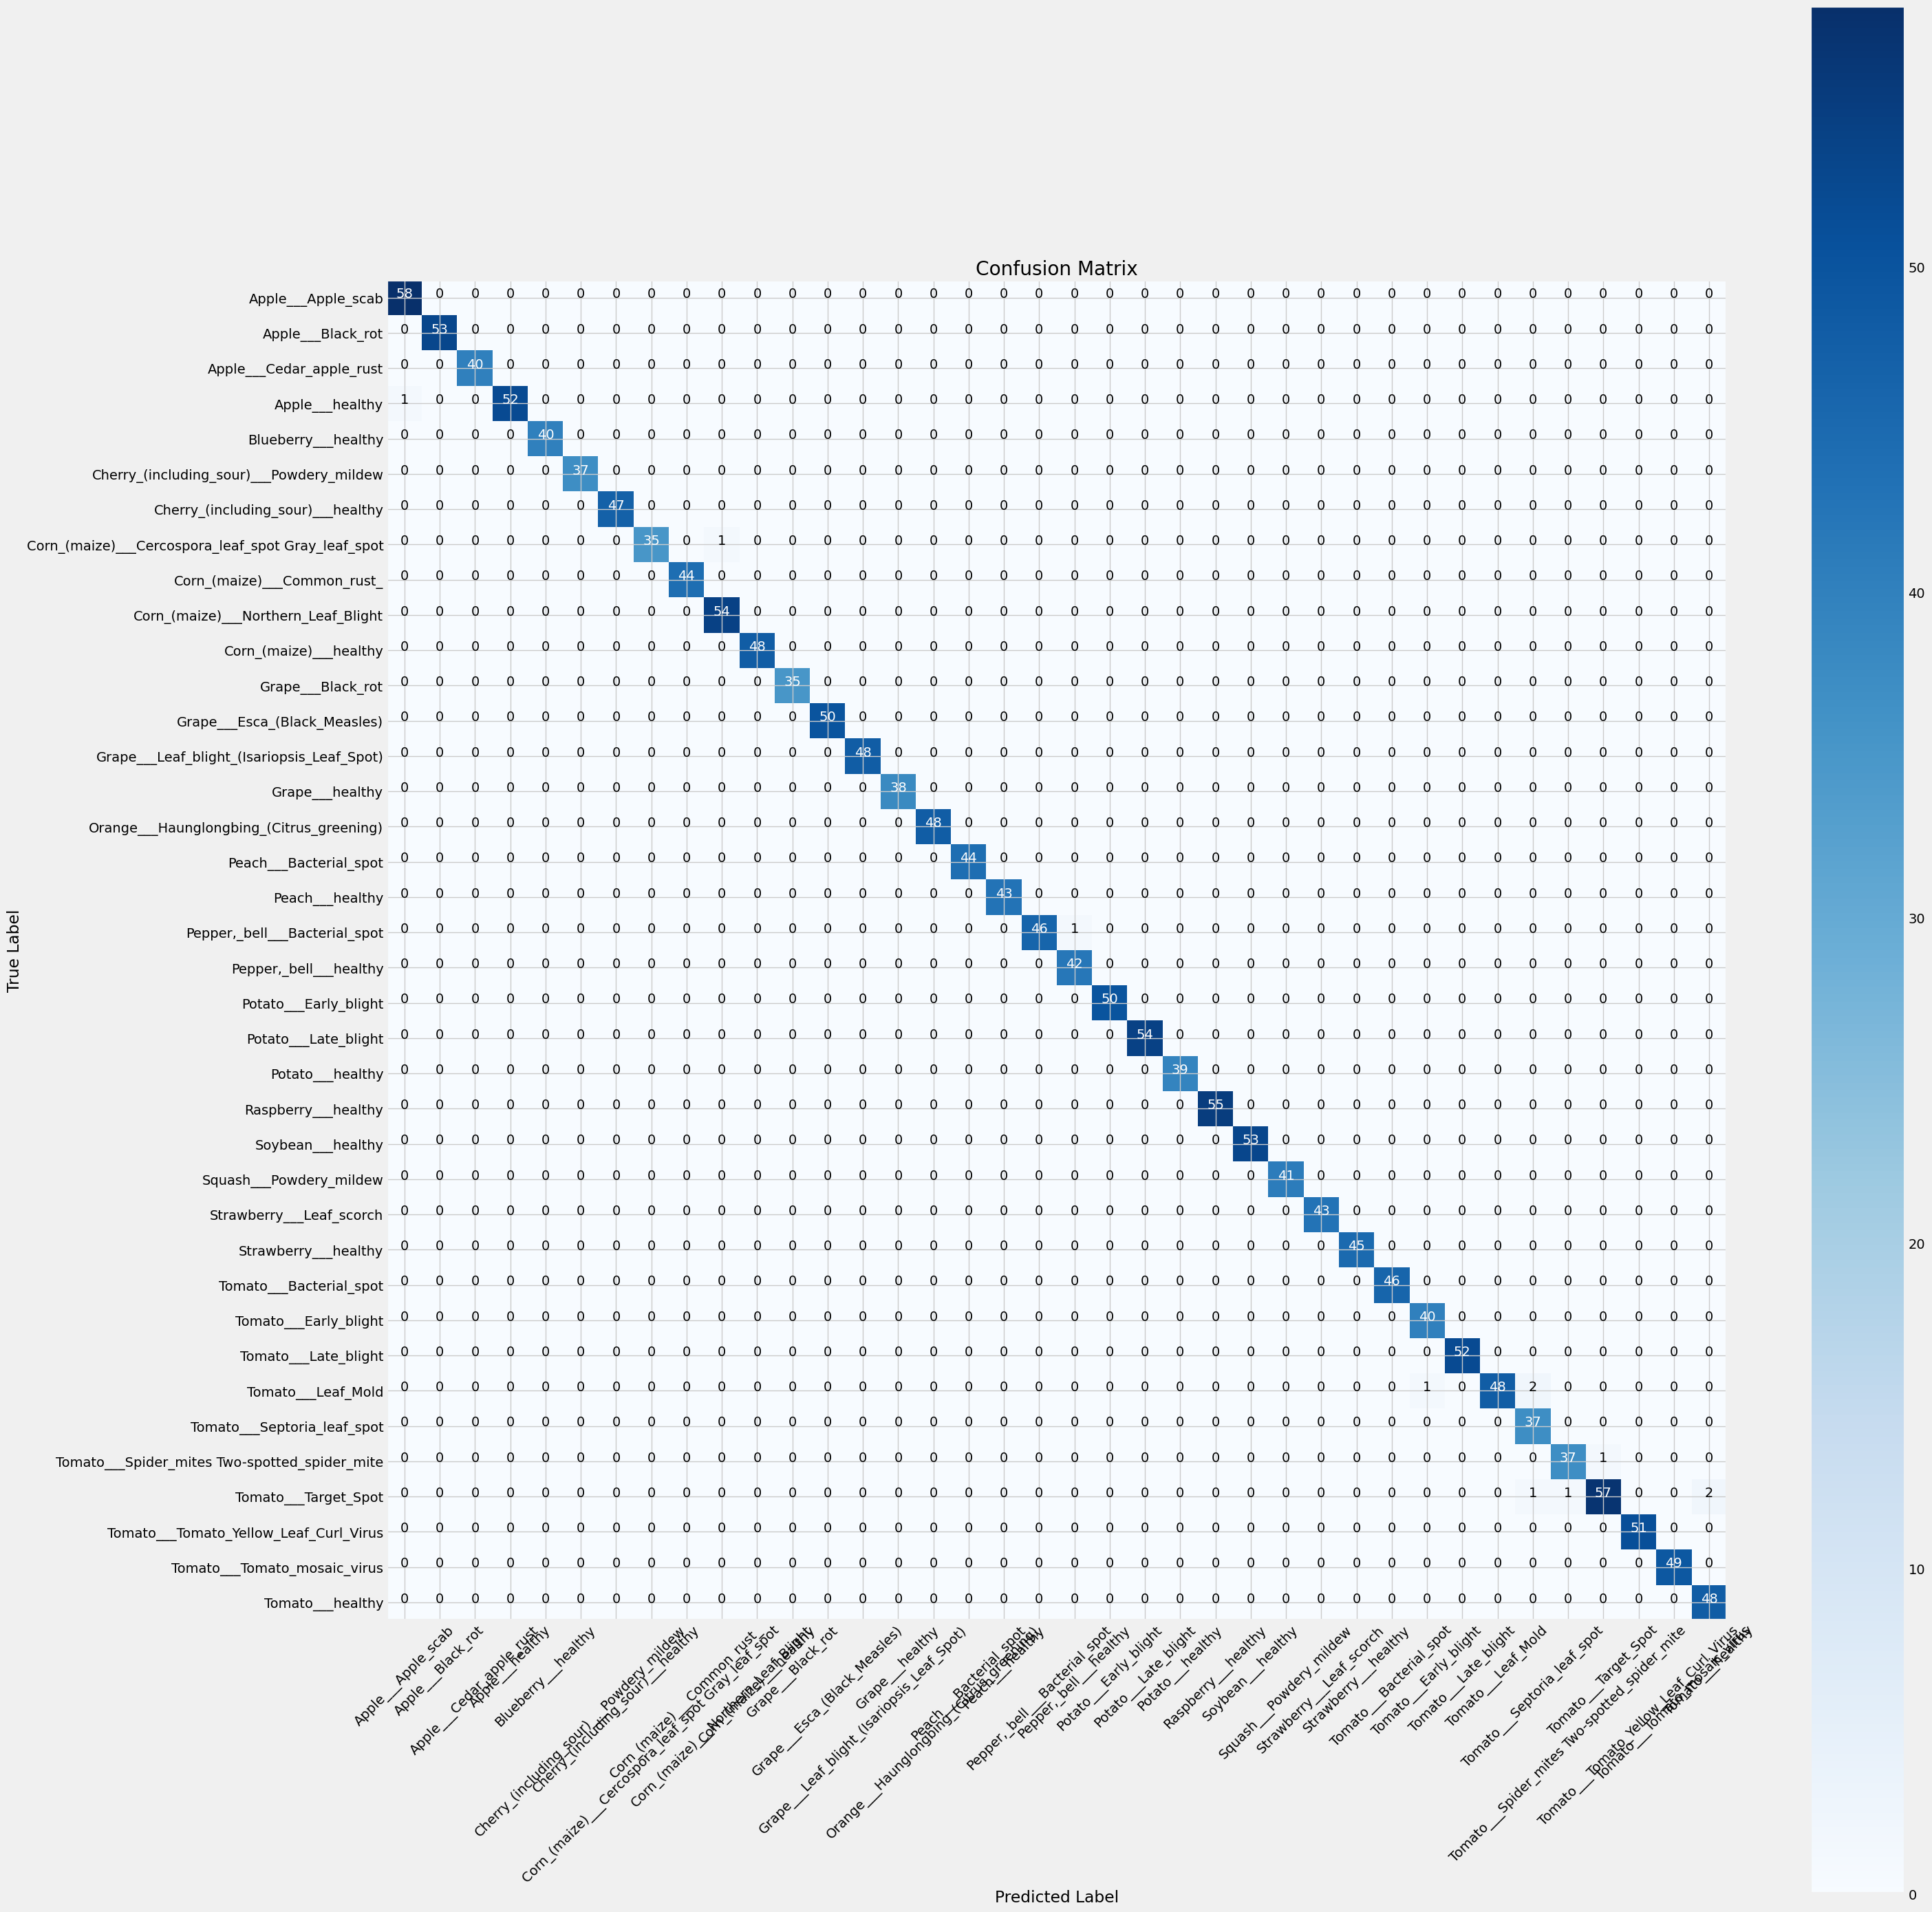

In [18]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
model.save('mobilenet_v3_large_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  